In [1]:
# =========================================
# Project: Link Analysis with PageRank
# Name & Surname: Honest A. Temu
# =========================================



# If running on Colab, install dependencies
!pip install -q kaggle pyspark networkx matplotlib seaborn

In [2]:
# Kaggle authentication & data download

import os

os.environ['KAGGLE_USERNAME'] = "XXXXXXXXXX"
os.environ['KAGGLE_KEY'] = "XXXXXXXXXXXXXXX"

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

!unzip -o amazon-books-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:07<00:00, 117MB/s] 
100% 1.06G/1.06G [00:07<00:00, 146MB/s]
Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


In [3]:
# Starting a spark session

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AmazonBooksPageRank") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

spark


In [4]:
# Global configuration
# Toggling subsampling for experimentation

USE_SUBSAMPLE = True
SUBSAMPLE_FRACTION = 0.05  # 5% of data

In [5]:
# Loading our dataset
from pyspark.sql.functions import col

# Loading CSV
reviews = spark.read.csv(
    "Books_rating.csv",
    header=True,
    inferSchema=True
)

print("Original rows:", reviews.count())

if USE_SUBSAMPLE:
    reviews = reviews.sample(fraction=SUBSAMPLE_FRACTION, seed=42)
    print("Subsampled rows:", reviews.count())

reviews.printSchema()

Original rows: 3000000
Subsampled rows: 150324
root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- User_id: string (nullable = true)
 |-- profileName: string (nullable = true)
 |-- review/helpfulness: string (nullable = true)
 |-- review/score: string (nullable = true)
 |-- review/time: string (nullable = true)
 |-- review/summary: string (nullable = true)
 |-- review/text: string (nullable = true)



In [6]:
# Data preps
from pyspark.sql.functions import explode, collect_set, countDistinct

# Rename columns for convenience
reviews = reviews.select(
    col("Id").alias("book_id"),
    col("User_id").alias("user_id"),
    col("review/score").alias("score")
).dropna()

In [7]:
print(reviews.count())


122180


In [8]:
# User graph construction

# For each book, collect users
book_users = reviews.groupBy("book_id") \
    .agg(collect_set("user_id").alias("users"))

# users linked if they reviewed at least one same book (mstari wa chini hapo)
user_edges = book_users \
    .withColumn("u1", explode("users")) \
    .withColumn("u2", explode("users")) \
    .filter(col("u1") != col("u2")) \
    .select(col("u1").alias("src"), col("u2").alias("dst")) \
    .distinct()

print("User edges:", user_edges.count())

User edges: 1928660


In [9]:
# Book graph construction

# For each user, collect books
user_books = reviews.groupBy("user_id") \
    .agg(collect_set("book_id").alias("books"))

# Books linked if reviewed by at least two common users (hapo kwenye filter)
book_edges = user_books \
    .withColumn("b1", explode("books")) \
    .withColumn("b2", explode("books")) \
    .filter(col("b1") != col("b2")) \
    .select(col("b1").alias("src"), col("b2").alias("dst")) \
    .groupBy("src", "dst") \
    .count() \
    .filter(col("count") >= 2) \
    .select("src", "dst")

print("Book edges:", book_edges.count())

Book edges: 3788


In [10]:
# PageRank w/ GraphFrames

from pyspark.sql.functions import lit, sum as spark_sum


def pagerank(edges, max_iter=10, damping=0.85):
    """
    Simple PageRank implementation in PySpark.
    Expects edges DataFrame with columns: src, dst
    """
    from pyspark.sql.functions import col, lit, sum as spark_sum

    # All vertices
    vertices = edges.select(col("src").alias("id")) \
        .union(edges.select(col("dst").alias("id"))) \
        .distinct()

    # Initialize ranks
    ranks = vertices.withColumn("rank", lit(1.0))

    for _ in range(max_iter):
        # Join edges with ranks on src
        contribs = edges.join(
            ranks,
            edges["src"] == ranks["id"],
            how="inner"
        ).groupBy("dst").agg(
            spark_sum("rank").alias("contrib")
        )

        # Update ranks
        ranks = vertices.join(
            contribs,
            vertices["id"] == contribs["dst"],
            how="left"
        ).fillna(0.0).select(
            vertices["id"],
            ((1 - damping) + damping * col("contrib")).alias("rank")
        )

    return ranks

# Run PageRank
user_ranks = pagerank(user_edges)
book_ranks = pagerank(book_edges)

In [11]:
# Top ranked users + books

print("Top Users")
user_ranks.orderBy(col("rank").desc()).show(10, truncate=False)



from pyspark.sql.functions import col
# Load book metadata (Id -> Title)
book_titles = spark.read.csv(
"Books_rating.csv",
header=True,
inferSchema=True
).select(
col("Id").alias("book_id"),
col("Title").alias("title")
).dropna().dropDuplicates(["book_id"])


# Join PageRank scores with titles
book_ranks_named = book_ranks.join(
book_titles,
book_ranks["id"] == book_titles["book_id"],
how="left"
).select(
col("book_id"),
col("title"),
col("rank")
)


print("Top Books with Titles")
book_ranks_named.orderBy(col("rank").desc()).show(20, truncate=False)


Top Users
+--------------+---------------------+
|id            |rank                 |
+--------------+---------------------+
|A1D2C0WDCSHUWZ|7.59223469061556E23  |
|A35PU6DDT4SJXK|6.308519027007409E23 |
|A259F4J3QOBIUH|5.794680330627901E23 |
|A311QBN2U5AIQN|4.304149118238791E23 |
|AWZ8FK8JGPYYG |3.978359502563528E23 |
|AVHBK2SJ6CJ1C |3.9664771526986045E23|
|AAIL33CYCT47J |3.8389472823323436E23|
|A2U21BHZJONNGD|3.833571640746973E23 |
|A2E5IE7HKSQJ7E|3.825675983338078E23 |
|A22GETHK36NV30|3.756503085013429E23 |
+--------------+---------------------+
only showing top 10 rows
Top Books with Titles
+----------+----------------------------------------+---------------------+
|book_id   |title                                   |rank                 |
+----------+----------------------------------------+---------------------+
|B000EVI8O0|Pride and Prejudice                     |1.8425225630048605E11|
|1901768945|Pride and Prejudice                     |1.8235574079991473E11|
|B000F6H01Q|Pride

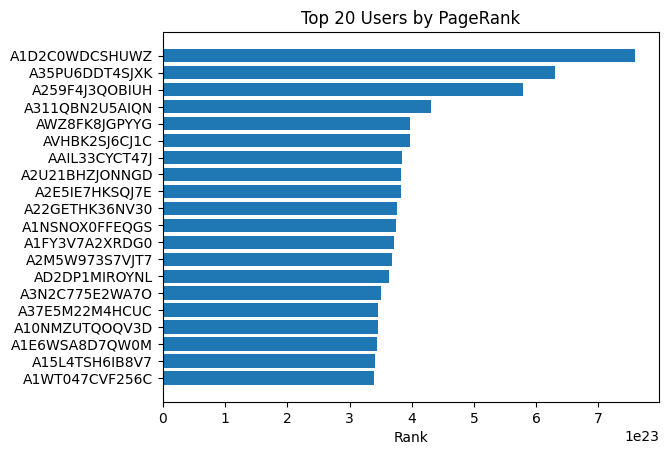

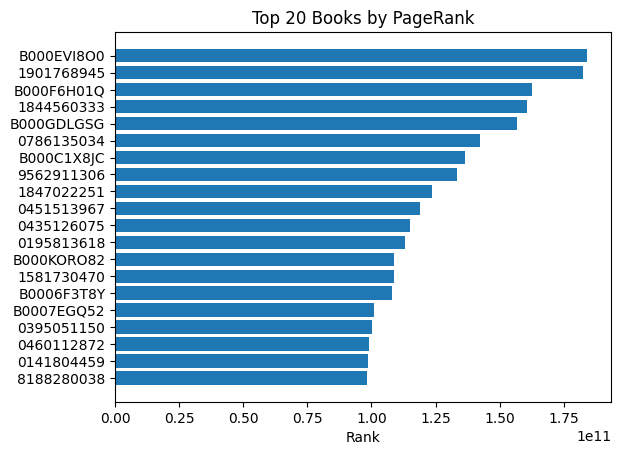

In [12]:
# Visualization (collect to Pandas)

import pandas as pd
import matplotlib.pyplot as plt

# Convert to pandas (top-N only for safety)
user_pd = user_ranks.orderBy(col("rank").desc()).limit(20).toPandas()
book_pd = book_ranks.orderBy(col("rank").desc()).limit(20).toPandas()

plt.figure()
plt.barh(user_pd['id'], user_pd['rank'])
plt.gca().invert_yaxis()
plt.title("Top 20 Users by PageRank")
plt.xlabel("Rank")
plt.show()

plt.figure()
plt.barh(book_pd['id'], book_pd['rank'])
plt.gca().invert_yaxis()
plt.title("Top 20 Books by PageRank")
plt.xlabel("Rank")
plt.show()



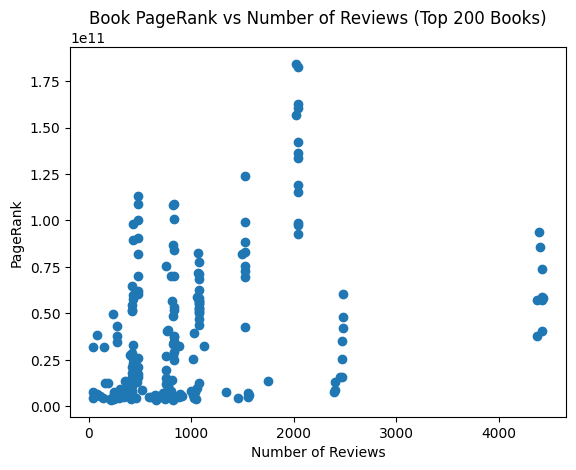

In [13]:
# PageRank vs Number of Reviews (Books)

from pyspark.sql.functions import count
import matplotlib.pyplot as plt


# Compute number of reviews per book
book_review_counts = spark.read.csv(
"Books_rating.csv",
header=True,
inferSchema=True
).groupBy("Id").agg(count("*").alias("num_reviews")) \
.withColumnRenamed("Id", "book_id")


# Join with PageRank + titles
book_pr_analysis = book_ranks_named.join(
book_review_counts,
on="book_id",
how="left"
)


# Limit to top-N books for visualization safety
TOP_N = 200
plot_pd = book_pr_analysis.orderBy(col("rank").desc()) \
.limit(TOP_N) \
.select("rank", "num_reviews") \
.toPandas()


# Scatter plot
plt.figure()
plt.scatter(plot_pd["num_reviews"], plot_pd["rank"])
plt.xlabel("Number of Reviews")
plt.ylabel("PageRank")
plt.title("Book PageRank vs Number of Reviews (Top {} Books)".format(TOP_N))
plt.show()

Power-law fit: PageRank ≈ exp(20.446) * reviews^0.521


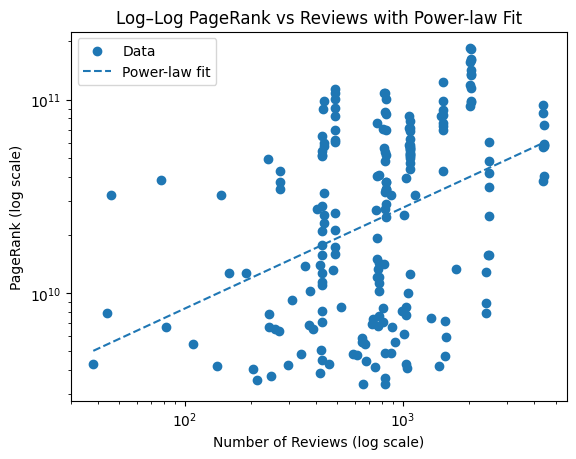

In [14]:
# Power-law Trend Line (Log–Log Fit)

import numpy as np

# Prepare data (avoid zeros for log scale)
log_pd = plot_pd[(plot_pd["num_reviews"] > 0) & (plot_pd["rank"] > 0)]


x = log_pd["num_reviews"]
y = log_pd["rank"]

# Fit linear model in log–log space: log(y) = a*log(x) + b
log_x = np.log(x)
log_y = np.log(y)


coeffs = np.polyfit(log_x, log_y, 1)
a, b = coeffs


print(f"Power-law fit: PageRank ≈ exp({b:.3f}) * reviews^{a:.3f}")


# Generate fitted line
x_fit = np.linspace(log_x.min(), log_x.max(), 100)
y_fit = a * x_fit + b


# Plot log–log with trend line
plt.figure()
plt.scatter(x, y, label="Data")
plt.plot(np.exp(x_fit), np.exp(y_fit), linestyle='--', label="Power-law fit")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Reviews (log scale)")
plt.ylabel("PageRank (log scale)")
plt.title("Log–Log PageRank vs Reviews with Power-law Fit")
plt.legend()
plt.show()